# "Parts of form" explorer

developed by Kow Kuroda (kow.kuroda@gmail.com)

Created 2024/09/13

Modifications
2025/08/01 i) added handling of Englsh WN3 word classification; ii) added gender sub-classification for Irish;
2025/08/02 i) added handling of Welsh;

In [21]:
#!pip install -U pyLDAvis
#!pip install -U pandas

In [22]:
## imports
import os, sys
import pprint as pp
import unicodedata

In [23]:
## 一つ上の階層のファイルを見るように設定
sys.path.append(os.path.join(os.path.dirname("__file__"), '..'))

In [24]:
## install Cython if necessary
#!conda install Cython -y

In [25]:
## Cython module の生成 (必要に応じて)
#!python clean setup.py build_ext --inplace

In [26]:
## Cython を使うかどうか
use_Cython = True
if use_Cython:
    %load_ext Cython

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [27]:
## doc settings
doc_types        = [ 'spell', 'sound' ]
doc_type          = doc_types[0]
print(f"doc_type: {doc_type}")

### boundary handling
mark_boundaries     = True
boundary_mark       = "#"
print(f"mark_boundaries with {boundary_mark}: {doc_type}")

## sizes
max_doc_size        = 11
min_doc_size        =  5
print(f"max_doc_size: {max_doc_size}")
print(f"min_doc_size: {min_doc_size}")

doc_type: spell
mark_boundaries with #: spell
max_doc_size: 11
min_doc_size: 5


In [28]:
## term settings
ngram_is_inclusive  = True
inclusion_degree    = None # or 1 # smaller values give better results

## term setting
#ngram_is_skippy       = False
skippy_means_extended = False

gap_mark            = "…"
seg_joint           = ""

### accent handling
suppress_accents    = True
accent_marks        = [ "ˈ", "ˌ" ] 
if doc_type == 'sound':
    if suppress_accents:
        accent_status = "-unaccented"
    else:
        accent_stratus = "-accented"
else:
    accent_status = ""
print(f"accent_status: {accent_status}")

accent_status: 


In [29]:
## select target files
import glob
data_dir1      = "data/open-dict-ipa/data1"
data_dir2      = "data/open-dict-ipa/data1a"
data_dir3      = "data/wn3"
data_dir4      = "data/irish"
data_dir5      = "data/welsh"
target_files   = glob.glob(f"{data_dir1}/*")
target_files2  = glob.glob(f"{data_dir2}/*")
target_files.extend(target_files2)
target_files3  = glob.glob(f"{data_dir3}/*")
target_files.extend(target_files3)
target_files4  = glob.glob(f"{data_dir4}/*")
target_files.extend(target_files4)
target_files5  = glob.glob(f"{data_dir5}/*")
target_files.extend(target_files5)
#
pp.pprint(target_files)

['data/open-dict-ipa/data1/yue.csv.gz',
 'data/open-dict-ipa/data1/vi_S.csv.gz',
 'data/open-dict-ipa/data1/de.csv.gz',
 'data/open-dict-ipa/data1/jam.csv.gz',
 'data/open-dict-ipa/data1/ro.csv.gz',
 'data/open-dict-ipa/data1/fa.csv.gz',
 'data/open-dict-ipa/data1/zh_hant.csv.gz',
 'data/open-dict-ipa/data1/sw.csv.gz',
 'data/open-dict-ipa/data1/ar.csv.gz',
 'data/open-dict-ipa/data1/es_MX.csv.gz',
 'data/open-dict-ipa/data1/vi_C.csv.gz',
 'data/open-dict-ipa/data1/ma.csv.gz',
 'data/open-dict-ipa/data1/fi.csv.gz',
 'data/open-dict-ipa/data1/eo.csv.gz',
 'data/open-dict-ipa/data1/fr_QC.csv.gz',
 'data/open-dict-ipa/data1/es_ES.csv.gz',
 'data/open-dict-ipa/data1/en_US.csv.gz',
 'data/open-dict-ipa/data1/en_UK.csv.gz',
 'data/open-dict-ipa/data1/nb.csv.gz',
 'data/open-dict-ipa/data1/nl.csv.gz',
 'data/open-dict-ipa/data1/sv.csv.gz',
 'data/open-dict-ipa/data1/or.csv.gz',
 'data/open-dict-ipa/data1/zh_hans.csv.gz',
 'data/open-dict-ipa/data1/fr_FR.csv.gz',
 'data/open-dict-ipa/data1/vi_

In [30]:
## key must be part of a file name 
target_lang_dict = {    'en_US' : 'English (US)',
                        'en_UK' : 'English (UK)',
                        'en_N_only' : 'English noun (WN)',
                        'en_V_only' : 'English verb (WN)',
                        'en_A_only' : 'English adj (WN)',
                        'en_R_only' : 'English adv (WN)',
                        'ar'    : 'Arabic',
                        'de'    : 'German',
                        'de_N_only' : 'German noun',
                        'de_non_N_only' : 'German non-noun',
                        'eo'    : 'Esperanto',
                        'es_ES' : 'Spanish (Spain)',
                        'es_MX' : 'Spanish (Mexico)',
                        'fi'    : 'Finnish',
                        'fr_FR' : 'French (France)',
                        'fr_QC' : 'French (Quebec)',
                        'is'    : 'Icelandic',
                        'ir'    : 'Irish',
                        'nb'    : 'Norwegian',
                        'nl'    : 'Dutch',
                        'ro'    : 'Romanian',
                        'sw'    : 'Swahili',
                        'we'    : 'Welsh' }
## proper language selection
target_lang_keys = [    'en_US', # 0
                        'en_UK', # 1
                        'en_N_only', # 2
                        'en_V_only', # 3
                        'en_A_only', # 4
                        'en_R_only', # 5
                        'ar', # 6
                        'de', # 7
                        'de_N_only', # 8
                        'de_non_N_only', # 9
                        'eo', 'es_ES', 'es_MX',
                        'fi', 'fr_FR', 'fr_QC',
                        'is', 'nb', 'nl', 'ro', 'sw',
                        'ir', 'we' # These lack sound
                    ]

In [31]:
## select language
target_lang_key  = target_lang_keys[-1]
print(f"target_lang_key: {target_lang_key}")
target_lang_name = target_lang_dict[target_lang_key]
print(f"target lang: {target_lang_name} [{target_lang_key}]")

target_lang_key: we
target lang: Welsh [we]


In [32]:
## select word class
selects_word_class = True

##
target_word_class = None
target_word_classes = [ 'N_only_w_gender', 'N_only_wo_gender', 'N_only',
                        'A_only_w_gender', 'A_only_wo_gender', 'A_only',
                        'non_N_only',
                        'R_only',
                        'V_only_w_inflect', 'V_only_wo_inflect', 'V_only' ]
# non_N_only only for German; R_only is not available for Irish, Welsh
target_word_class = target_word_classes[3]
print(f"target_word_class: {target_word_class}")

##
selects_gender  = False
selects_inflect = False
if "w_gender" in target_word_class:
    selects_gender = True
elif "w_inflect" in target_word_class:
    selects_inflect = True
print(f"selects_gender: {selects_gender}")
print(f"selects_inflect: {selects_inflect}")    

target_word_class: A_only_w_gender
selects_gender: True
selects_inflect: False


In [33]:
## select files

## make a reserve for re-run
try:
    target_files_original
except NameError:
    target_files_original = target_files.copy()
##
if selects_word_class:
    lang_key = target_lang_key.split("_")[0]
    print(f"lang_key: {lang_key}")
    print(f"target_word_class: {target_word_class}")
    if not target_word_class != 'non_N_only':
        target_files = [ f for f in target_files_original if not f"non_{target_word_class}" in f ]
    if type(target_word_class) == 'list':
        target_files = [ f for f in target_files if any(wc in f for wc in target_word_class) and lang_key in f ]
    else:
        target_files = [ f for f in target_files if target_word_class in f and lang_key in f ]
##
pp.pprint(target_files)

lang_key: we
target_word_class: A_only_w_gender
['data/welsh/welsh-spell-A_only_w_gender.csv']


In [34]:
## get source data from files
import pandas as pd
import gzip

for target_file in target_files:
    print(f"processing: {target_file}")
    #
    if target_lang_key in ['wl', 'we']:
        col_names = ['spell', 'lemma', 'POS0', 'POS', 'freq']
    elif target_lang_key in ['ir', ]:
        col_names = ['spell', 'POS']
    else:
        col_names = ['spell', 'sound']
    ##
    if target_file.endswith(".gz"):
        with gzip.open(target_file, "rt") as f:
            df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )
    else:
        with open(target_file, "rt") as f:
            df = pd.read_csv(f, encoding = 'utf8', header = None, names = col_names )

    ## normalize characters
    df['spell'] = df['spell'].apply(lambda x: unicodedata.normalize('NFC', str(x)))

    ## modify sound
    try:
        sounds = df['sound'].apply(lambda x: x.strip('/') )
        sounds = [ x.split("/,")[0] for x in sounds ] # picks up only the first of multiple entries
        df['sound'] = sounds
    except (AttributeError, KeyError):
        pass
    #
df.sample(30)

processing: data/welsh/welsh-spell-A_only_w_gender.csv


,spell,lemma,POS0,POS,freq
735,werdd,gwerdd,Adj,Adj.common.fem.sg,3
982,bâs,bas,Adj,Adj.common.masc.sg,1
916,cyfforddus,cyfforddus,Adj,Adj.common.masc.sg,3
505,clwyfedig,clwyfedig,Adj,Adj.common.masc.sg,1
684,darawiadol,trawiadol,Adj,Adj.common.masc.sg,1
315,ddirgel,dirgel,Adj,Adj.common.masc.sg,2
1124,tlodaidd,tlawd,Adj,Adj.common.masc.sg,1
1150,eiddgar,eiddgar,Adj,Adj.common.masc.sg,1
42,bosibl,posibl,Adj,Adj.common.masc.sg,13
865,hurt,hurt,Adj,Adj.common.masc.sg,4


### Noun gender

In [ ]:
## select gender value
#selects_gender = False
target_genders = [ 'fem', 'masc', 'neu' ] # neuter is effective for German only
target_gender = target_genders[1]
print(f"target_gender: {target_gender}")

target_gender: masc


In [36]:
## make a reserve for re-run
try:
    df_origin
except NameError:
    df_origin = df.copy()

In [37]:
df_origin

,spell,lemma,POS0,POS,freq
0,hanesyddol,hanesyddol,Adj,Adj.common.masc.sg,6
1,anwadal,anwadal,Adj,Adj.common.masc.sg,1
2,gogoneddus,gogoneddus,Adj,Adj.common.masc.sg,3
3,unig,unig,Adj,Adj.common.masc.sg,52
4,isel,isel,Adj,Adj.common.masc.sg,13
...,...,...,...,...,...
1182,cyhoeddedig,cyhoeddedig,Adj,Adj.common.masc.sg,1
1183,unol,unol,Adj,Adj.common.masc.sg,1
1184,cydweithredol,cydweithredol,Adj,Adj.common.masc.sg,1
1185,buddug,buddig,Adj,Adj.common.masc.sg,1


In [40]:
## filter df
import re
pattern = re.compile(f".*{target_gender}.*")

## Welsh
if selects_gender and target_lang_key in [ 'we', 'wl' ] and target_word_class in [ 'N_only_w_gender', 'A_only_w_gender' ]:
    df = df_origin[df_origin['POS'].apply(lambda x: bool(pattern.match(x)))]
## Irish
elif selects_gender and target_lang_key in [ 'ir' ] and target_word_class in [ 'N_only_w_gender' ]:
    df = df_origin[df_origin['POS'].apply(lambda x: pattern.match(x))]
## Other
else:
    target_gender = None
#
df

,spell,lemma,POS0,POS,freq
0,hanesyddol,hanesyddol,Adj,Adj.common.masc.sg,6
1,anwadal,anwadal,Adj,Adj.common.masc.sg,1
2,gogoneddus,gogoneddus,Adj,Adj.common.masc.sg,3
3,unig,unig,Adj,Adj.common.masc.sg,52
4,isel,isel,Adj,Adj.common.masc.sg,13
...,...,...,...,...,...
1182,cyhoeddedig,cyhoeddedig,Adj,Adj.common.masc.sg,1
1183,unol,unol,Adj,Adj.common.masc.sg,1
1184,cydweithredol,cydweithredol,Adj,Adj.common.masc.sg,1
1185,buddug,buddig,Adj,Adj.common.masc.sg,1


### Verb inflection

In [41]:
## select inflection value
#selects_inflect = True
target_inflect = ['inf', 'indic', 'imper', 'subj',
                   'p1', 'p2', 'p3', 'p0'
                  'sg', 'pl' ] # neuter is effective for German only
target_inflect = target_inflect[5]
print(f"target_inflect: {target_inflect}")

## disable selects_gender
if selects_inflect:
    selects_gender = False

target_inflect: p2


In [42]:
## filer df
import re
if selects_inflect and target_lang_key in [ 'we', 'wl' ] and target_word_class in [ 'V_only_w_inflect' ]:
    pattern = re.compile(f".*{target_inflect}.*")
    df = df_origin[df_origin['POS'].apply(lambda x: bool(pattern.match(x)))]
## Other cases
else:
    target_inflect = None
#
df

,spell,lemma,POS0,POS,freq
0,hanesyddol,hanesyddol,Adj,Adj.common.masc.sg,6
1,anwadal,anwadal,Adj,Adj.common.masc.sg,1
2,gogoneddus,gogoneddus,Adj,Adj.common.masc.sg,3
3,unig,unig,Adj,Adj.common.masc.sg,52
4,isel,isel,Adj,Adj.common.masc.sg,13
...,...,...,...,...,...
1182,cyhoeddedig,cyhoeddedig,Adj,Adj.common.masc.sg,1
1183,unol,unol,Adj,Adj.common.masc.sg,1
1184,cydweithredol,cydweithredol,Adj,Adj.common.masc.sg,1
1185,buddug,buddig,Adj,Adj.common.masc.sg,1


## sampling

In [43]:
## source sampling
source_sampling          = True
source_sampling_rate     = 0.5
source_sampling_max_size = 3000
len(df)
if source_sampling:
	print(f"source sampling applied")
	if len(df) >= source_sampling_max_size:
		source_sampling_n = source_sampling_max_size
	else:
		source_sampling_n = round(len(df) * source_sampling_rate)
	df = df.sample(source_sampling_n)
else:
	source_sampling_n = None

## remove accent marking
if suppress_accents:
	try:
		df['sound'] = df['sound'].apply(lambda x: "".join([ y for y in list(x) if y not in accent_marks ]))
	except KeyError:
		pass

## add boudary marks
if mark_boundaries:
	df['spell'] = df['spell'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	try:
		df['sound'] = df['sound'].apply(lambda x: f"{boundary_mark}{x}{boundary_mark}")
	except KeyError:
		pass
#
print(df)

source sampling applied
          spell    lemma POS0                 POS  freq
22       #theg#      teg  Adj  Adj.common.masc.sg     1
725     #ddwys#     dwys  Adj  Adj.common.masc.sg     8
1014    #astud#    astud  Adj  Adj.common.masc.sg     1
179    #tywyll#   tywyll  Adj  Adj.common.masc.sg     2
389      #moel#     moel  Adj  Adj.common.masc.sg     3
...         ...      ...  ...                 ...   ...
1026    #cloff#    cloff  Adj  Adj.common.masc.sg     1
724   #ddistaw#   distaw  Adj  Adj.common.masc.sg    22
615     #ysgwn#    ysgwn  Adj  Adj.common.masc.sg     1
233   #cyfiawn#  cyfiawn  Adj  Adj.common.masc.sg     3
374    #ffodus#   ffodus  Adj  Adj.common.masc.sg     1

[548 rows x 5 columns]


In [44]:
## generate 1-grams for spell and sound
## spell
df['sp_1gram'] = df['spell'].apply(lambda x: list(str(x)))
# add column of size
df['sp_size'] = df['sp_1gram'].apply(lambda x: len(x))
# add column of count of '-' inside
df['hyphen'] = df['sp_1gram'].apply(lambda x: list(x).count("-"))
# add column of count of '.' inside
df['period'] = df['sp_1gram'].apply(lambda x: list(x).count("."))
## sound
# takes the first entry, removes '/' around
try:
    df['sn_1gram'] = df['sound'].apply(lambda x: list(x) )
except (TypeError, KeyError):
    pass
# add column of size
try:
    df['sn_size'] = df['sn_1gram'].apply(lambda x: len(x))
except KeyError:
    pass
## check
df

,spell,lemma,POS0,POS,freq,sp_1gram,sp_size,hyphen,period
22,#theg#,teg,Adj,Adj.common.masc.sg,1,"[#, t, h, e, g, #]",6,0,0
725,#ddwys#,dwys,Adj,Adj.common.masc.sg,8,"[#, d, d, w, y, s, #]",7,0,0
1014,#astud#,astud,Adj,Adj.common.masc.sg,1,"[#, a, s, t, u, d, #]",7,0,0
179,#tywyll#,tywyll,Adj,Adj.common.masc.sg,2,"[#, t, y, w, y, l, l, #]",8,0,0
389,#moel#,moel,Adj,Adj.common.masc.sg,3,"[#, m, o, e, l, #]",6,0,0
...,...,...,...,...,...,...,...,...,...
1026,#cloff#,cloff,Adj,Adj.common.masc.sg,1,"[#, c, l, o, f, f, #]",7,0,0
724,#ddistaw#,distaw,Adj,Adj.common.masc.sg,22,"[#, d, d, i, s, t, a, w, #]",9,0,0
615,#ysgwn#,ysgwn,Adj,Adj.common.masc.sg,1,"[#, y, s, g, w, n, #]",7,0,0
233,#cyfiawn#,cyfiawn,Adj,Adj.common.masc.sg,3,"[#, c, y, f, i, a, w, n, #]",9,0,0


In [45]:
## filtering raw_data by size
print(f"term_class: {doc_type}")
if "spell" == doc_type:
    df_filtered = df[ (df['sp_size'] <= max_doc_size) & (df['sp_size'] >= min_doc_size) & (df['hyphen'] == 0) & (df['period'] == 0) ]
else:
    df_filtered = df[ (df['sn_size'] <= max_doc_size) & (df['sn_size'] >= min_doc_size) ]
#
df_filtered

term_class: spell


,spell,lemma,POS0,POS,freq,sp_1gram,sp_size,hyphen,period
22,#theg#,teg,Adj,Adj.common.masc.sg,1,"[#, t, h, e, g, #]",6,0,0
725,#ddwys#,dwys,Adj,Adj.common.masc.sg,8,"[#, d, d, w, y, s, #]",7,0,0
1014,#astud#,astud,Adj,Adj.common.masc.sg,1,"[#, a, s, t, u, d, #]",7,0,0
179,#tywyll#,tywyll,Adj,Adj.common.masc.sg,2,"[#, t, y, w, y, l, l, #]",8,0,0
389,#moel#,moel,Adj,Adj.common.masc.sg,3,"[#, m, o, e, l, #]",6,0,0
...,...,...,...,...,...,...,...,...,...
1026,#cloff#,cloff,Adj,Adj.common.masc.sg,1,"[#, c, l, o, f, f, #]",7,0,0
724,#ddistaw#,distaw,Adj,Adj.common.masc.sg,22,"[#, d, d, i, s, t, a, w, #]",9,0,0
615,#ysgwn#,ysgwn,Adj,Adj.common.masc.sg,1,"[#, y, s, g, w, n, #]",7,0,0
233,#cyfiawn#,cyfiawn,Adj,Adj.common.masc.sg,3,"[#, c, y, f, i, a, w, n, #]",9,0,0


In [46]:
## second sampling if needed
second_sampling          = False
second_sampling_rate     = 0.7
len(df_filtered)
if second_sampling:
    df = df_filtered.sample(round(len(df_filtered) * second_sampling_rate))
else:
    df = df_filtered
len(df)

476

# Functions

In [47]:
def add_ngram_to_df(dfx, n_for_ngram: int, skippy: bool, prefix: str = "", seg_joint: str = "", missing_mark: str = gap_mark, max_distance = None, inclusive: bool = ngram_is_inclusive, inclusion_degree = None, use_Cython: bool = False, check: bool = False):
    """
    generic function for adding n-gram column to df with a specified n for ngram
    """
    ## variables
    source_var = f"{prefix}1gram"
    print(f"source_var: {source_var}")
    if skippy:
        target_var = f"{prefix}sk{n_for_ngram}gram"
    else:
        target_var = f"{prefix}{n_for_ngram}gram"
    print(f"target_var: {target_var}")
    
    ##
    unigrams = dfx[source_var]
    if use_Cython:
        import cy_gen_ngrams
        if skippy:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, missing_mark = missing_mark, max_distance = max_distance, check = check)] for x in unigrams ]
        else:
            ngrams = [ [seg_joint.join(x) for x in cy_gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check)] for x in unigrams ]
    else:
        import gen_ngrams
        if skippy:
            ngrams = [ gen_ngrams.gen_skippy_ngrams(x, n = n_for_ngram, sep = seg_joint, missing_mark = missing_mark, max_distance = max_distance, check = check) for x in unigrams ]
        else:
            ngrams = [ gen_ngrams.gen_ngrams(x, n = n_for_ngram, sep = seg_joint, check = check) for x in unigrams ]
    ## 包括的 n-gramの生成
    if inclusive:
        if inclusion_degree is None:
            min_size = 1
        else:
            min_size = (n_for_ngram - inclusion_degree)
        print(f"min_size: {min_size}")
        assert min_size >= 0
        if skippy and n_for_ngram > 2:
            supplement_var = f"{prefix}sk{n_for_ngram - 1}gram"
        else:
            supplement_var = f"{prefix}{n_for_ngram - 1}gram"
        print(f"supplement_var: {supplement_var}")
        for i, g in enumerate(ngrams):
            supplement = [ x for x in list(dfx[supplement_var])[i] if len(x) >= min_size ]
            if len(supplement) > 0:
                g.extend(supplement)
    ## 変数の追加
    dfx[target_var] = ngrams
    ## check result
    print(dfx[target_var])

In [48]:
def get_terms_by_freq_rank(dfx, rank_range: tuple, prefix: str = "", n_for_ngram: int = 2, skippy: bool = False, gap_mark: str = "…", check = False):
    "return list of most N frequent terms"
    import collections
    ## define variables
    if skippy:
        if skippy_means_extended:
            skippiness = "xsk"
        else:
            skippiness = "sk"
    else:
        skippiness = "" 
    var_name = f'{prefix}{skippiness}{n_for_ngram}gram'
    if check:
        print(f"var_name: {var_name}")
    ## main
    G = [ ]
    [ G.extend([x for x in L if len(x.replace(gap_mark, "")) == n_for_ngram]) for L in dfx[var_name] ]
    if check:
        print(G)
    ## filtering data
    highest_rank = min(rank_range)
    lowest_rank  = max(rank_range)
    if check:
        print(f"highest_rank: {highest_rank}; lowest_rank: {lowest_rank}")
    R = collections.Counter(G).most_common(lowest_rank)
    R = R[(highest_rank - 1):]
    if check:
        print(R)
    ## return
    return R

In [68]:
def show_terms_with_ranking(ranking, rank_range: tuple, n_for_ngram: int, skippy: bool, prefix: str = "", lang: str = target_lang_name, word_class: str = target_word_class, gender_val: str = target_gender, inflect_val: str = target_inflect, check = False):
    "display terms with a given frequency rank range"
    ## imports
    import matplotlib.pyplot as plt
    ## variables
    highest_rank = min(rank_range)
    lowest_rank  = max(rank_range)
    if skippy:
        if skippy_means_extended:
            skippiness = "xsk"
        else:
            skippiness = "sk"
    else:
        skippiness = ""
    target_var_name = f"{prefix}{skippiness}{n_for_ngram}g"

    ## get freq data
    ranking = sorted(ranking, key = lambda x: x[1], reverse = False)
    terms, freqs = [ ], [ ]
    for x in ranking:
        term, freq = x[0], x[1]
        if len(term) > 0 and freq > 0:
            terms.append(term)
            freqs.append(freq)

    ## plot
    plt.figure(figsize = (6, 0.25 * len(terms)))
    plt.autoscale(enable = True, axis = 'y', tight = True)
    plt.barh(terms, freqs)
    ##
    if gender_val is not None:
        title_val = f"Freq-ranked distribution [rank {highest_rank} – rank {lowest_rank}] of {target_var_name} from\n{lang} ({source_sampling_n} samples from word_class: {word_class} with: {gender_val}) "
    elif inflect_val is not None:
        title_val = f"Freq-ranked distribution [rank {highest_rank} – rank {lowest_rank}] of {target_var_name} from\n{lang} ({source_sampling_n} samples from word_class: {word_class} with: {inflect_val}) "
    else:
        title_val = f"Freq-ranked distribution [rank {highest_rank} - rank {lowest_rank}] of {target_var_name} from\n{lang} ({source_sampling_n} samples from word_class: {word_class})"
    plt.title(title_val)
    plt.plot()

# Main

In [69]:
# frequency rank range for terms to show
highest_freq_rank_for_terms_to_show = 1
lowest_freq_rank_for_terms_to_show  = 100
rank_range  = (highest_freq_rank_for_terms_to_show, lowest_freq_rank_for_terms_to_show)
print(f"rank_range: {rank_range}")

rank_range: (1, 100)


## Spell

### Non-skippy spell

In [70]:
## spell 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_2gram
min_size: 1
supplement_var: sp_1gram
22                 [#t, th, he, eg, g#, #, t, h, e, g, #]
725         [#d, dd, dw, wy, ys, s#, #, d, d, w, y, s, #]
1014        [#a, as, st, tu, ud, d#, #, a, s, t, u, d, #]
179     [#t, ty, yw, wy, yl, ll, l#, #, t, y, w, y, l,...
389                [#m, mo, oe, el, l#, #, m, o, e, l, #]
                              ...                        
1026        [#c, cl, lo, of, ff, f#, #, c, l, o, f, f, #]
724     [#d, dd, di, is, st, ta, aw, w#, #, d, d, i, s...
615         [#y, ys, sg, gw, wn, n#, #, y, s, g, w, n, #]
233     [#c, cy, yf, fi, ia, aw, wn, n#, #, c, y, f, i...
374     [#f, ff, fo, od, du, us, s#, #, f, f, o, d, u,...
Name: sp_2gram, Length: 476, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25653/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


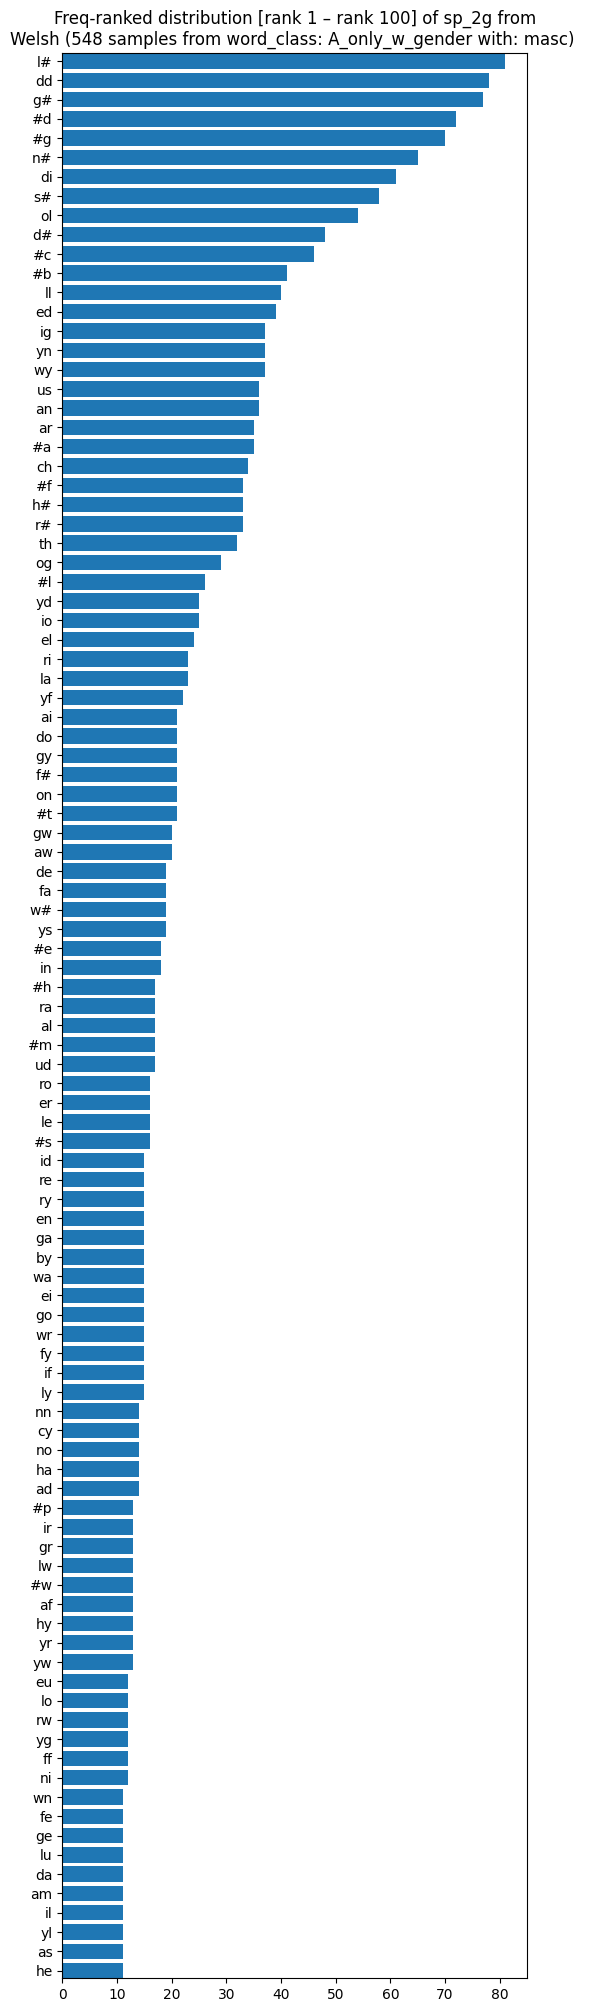

In [71]:
## frequency-ranked view
skippy = False
prefix = "sp_"
n_local = 2
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [72]:
## spell 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_3gram
min_size: 1
supplement_var: sp_2gram
22      [#th, the, heg, eg#, #t, th, he, eg, g#, #, t,...
725     [#dd, ddw, dwy, wys, ys#, #d, dd, dw, wy, ys, ...
1014    [#as, ast, stu, tud, ud#, #a, as, st, tu, ud, ...
179     [#ty, tyw, ywy, wyl, yll, ll#, #t, ty, yw, wy,...
389     [#mo, moe, oel, el#, #m, mo, oe, el, l#, #, m,...
                              ...                        
1026    [#cl, clo, lof, off, ff#, #c, cl, lo, of, ff, ...
724     [#dd, ddi, dis, ist, sta, taw, aw#, #d, dd, di...
615     [#ys, ysg, sgw, gwn, wn#, #y, ys, sg, gw, wn, ...
233     [#cy, cyf, yfi, fia, iaw, awn, wn#, #c, cy, yf...
374     [#ff, ffo, fod, odu, dus, us#, #f, ff, fo, od,...
Name: sp_3gram, Length: 476, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25653/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


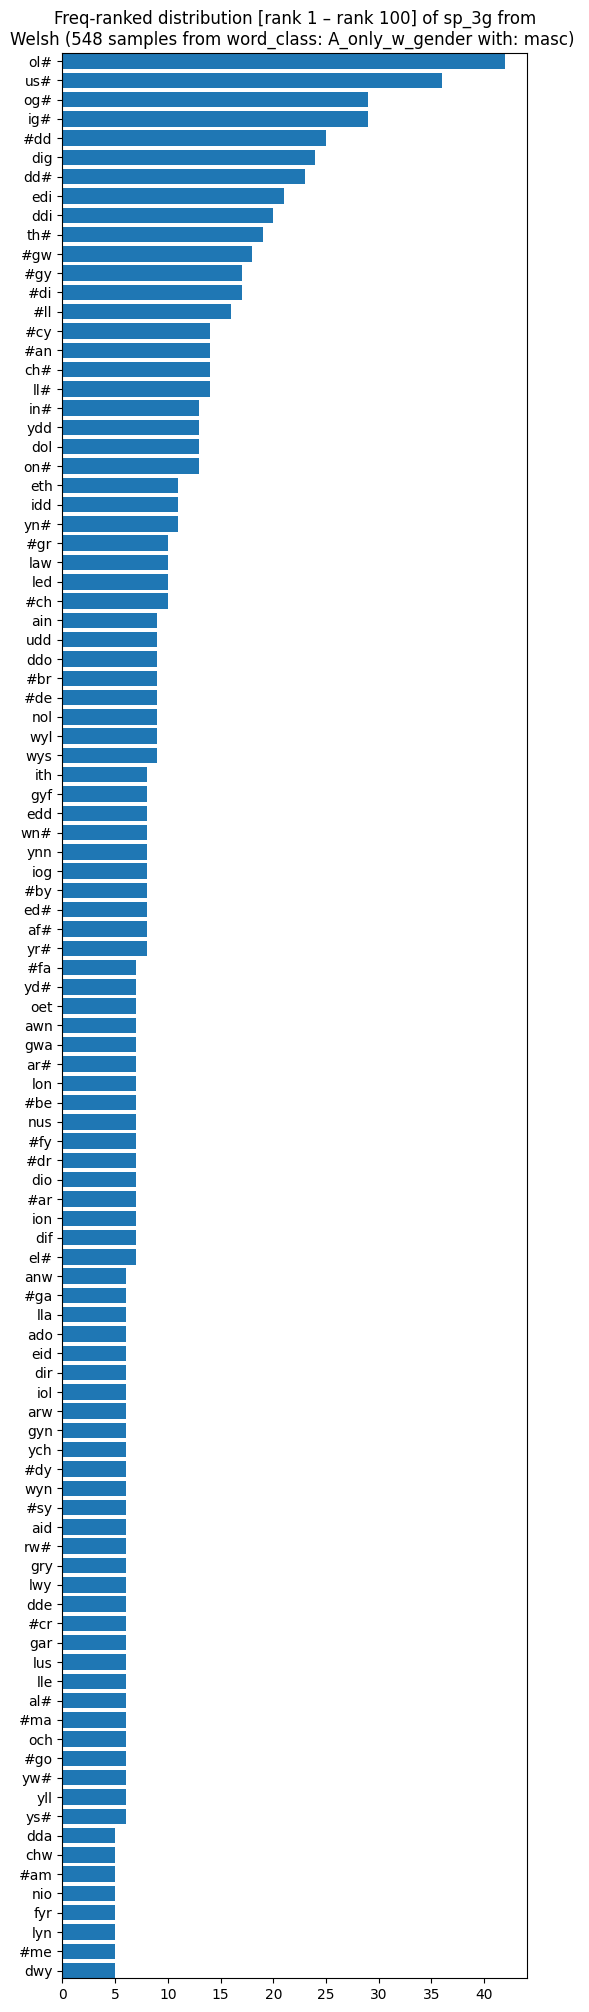

In [73]:
## frequency-ranke view
skippy = False
prefix = "sp_"
n_local = 3
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [74]:
## spell 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_4gram
min_size: 1
supplement_var: sp_3gram
22      [#the, theg, heg#, #th, the, heg, eg#, #t, th,...
725     [#ddw, ddwy, dwys, wys#, #dd, ddw, dwy, wys, y...
1014    [#ast, astu, stud, tud#, #as, ast, stu, tud, u...
179     [#tyw, tywy, ywyl, wyll, yll#, #ty, tyw, ywy, ...
389     [#moe, moel, oel#, #mo, moe, oel, el#, #m, mo,...
                              ...                        
1026    [#clo, clof, loff, off#, #cl, clo, lof, off, f...
724     [#ddi, ddis, dist, ista, staw, taw#, #dd, ddi,...
615     [#ysg, ysgw, sgwn, gwn#, #ys, ysg, sgw, gwn, w...
233     [#cyf, cyfi, yfia, fiaw, iawn, awn#, #cy, cyf,...
374     [#ffo, ffod, fodu, odus, dus#, #ff, ffo, fod, ...
Name: sp_4gram, Length: 476, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25653/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


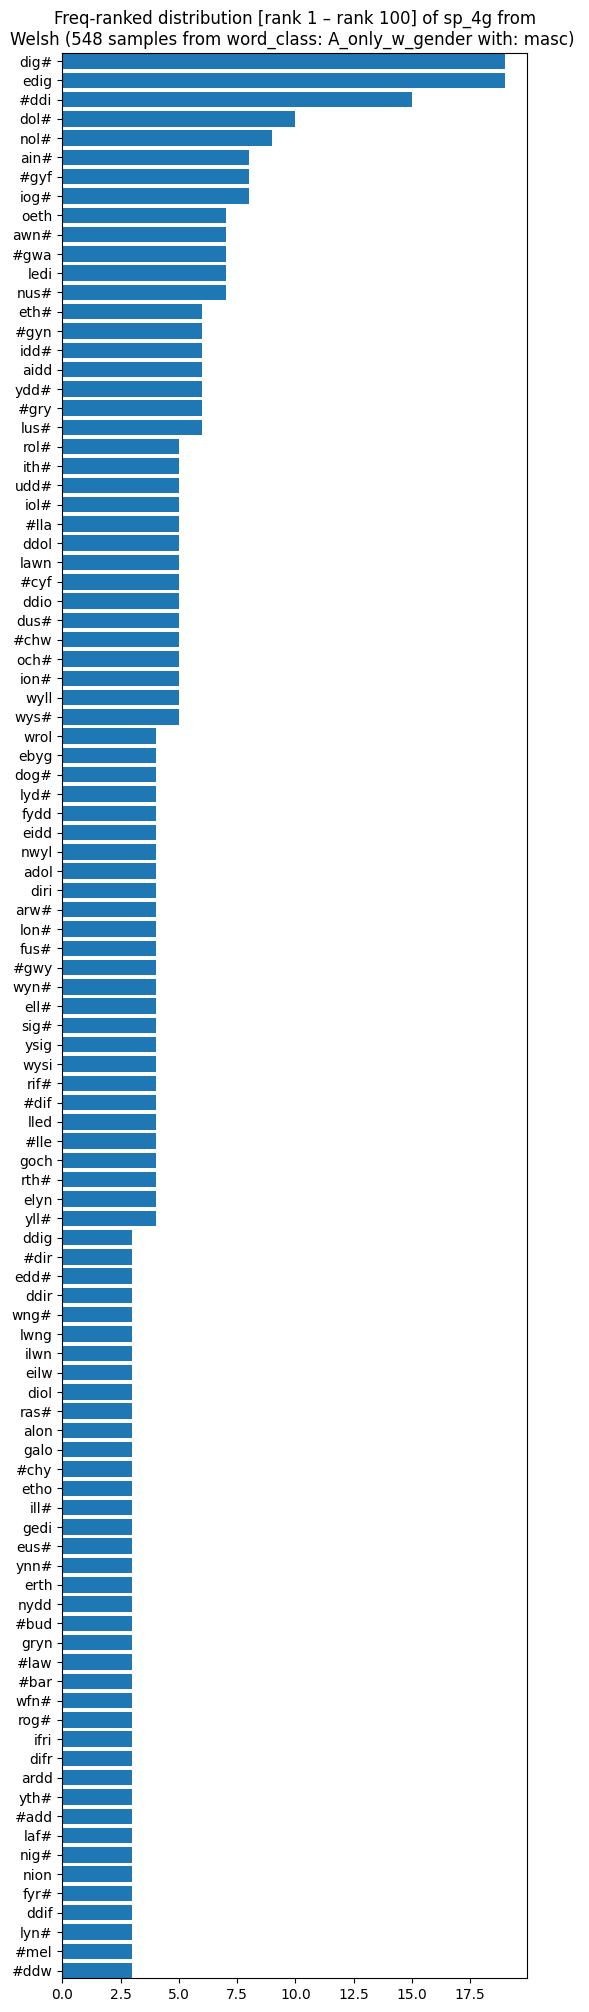

In [75]:
## frequency-ranke view
skippy = False
prefix = "sp_"
n_local = 4
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [76]:
## spell 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = False, inclusive = True, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_5gram
min_size: 1
supplement_var: sp_4gram
22      [#theg, theg#, #the, theg, heg#, #th, the, heg...
725     [#ddwy, ddwys, dwys#, #ddw, ddwy, dwys, wys#, ...
1014    [#astu, astud, stud#, #ast, astu, stud, tud#, ...
179     [#tywy, tywyl, ywyll, wyll#, #tyw, tywy, ywyl,...
389     [#moel, moel#, #moe, moel, oel#, #mo, moe, oel...
                              ...                        
1026    [#clof, cloff, loff#, #clo, clof, loff, off#, ...
724     [#ddis, ddist, dista, istaw, staw#, #ddi, ddis...
615     [#ysgw, ysgwn, sgwn#, #ysg, ysgw, sgwn, gwn#, ...
233     [#cyfi, cyfia, yfiaw, fiawn, iawn#, #cyf, cyfi...
374     [#ffod, ffodu, fodus, odus#, #ffo, ffod, fodu,...
Name: sp_5gram, Length: 476, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25653/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


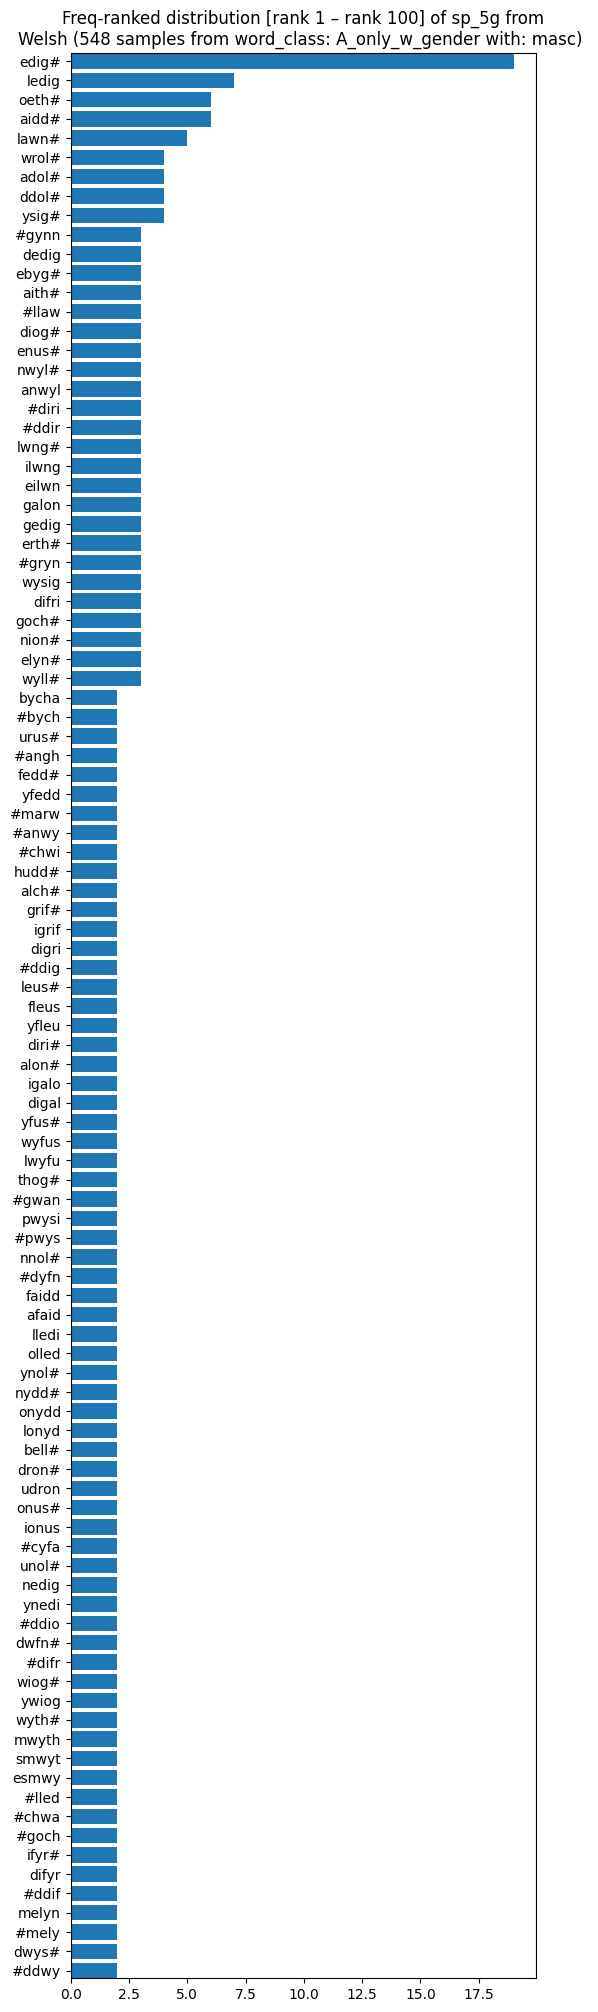

In [77]:
## frequency-rank view
skippy = False
prefix = "sp_"
n_local = 5
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

### skippy spell

In [78]:
## spell skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk2gram
min_size: 1
supplement_var: sp_1gram
22      [#t, #…h, #…e, #…g, #…#, th, t…e, t…g, t…#, he...
725     [#d, #…d, #…w, #…y, #…s, #…#, dd, d…w, d…y, d…...
1014    [#a, #…s, #…t, #…u, #…d, #…#, as, a…t, a…u, a…...
179     [#t, #…y, #…w, #…y, #…l, #…l, #…#, ty, t…w, t…...
389     [#m, #…o, #…e, #…l, #…#, mo, m…e, m…l, m…#, oe...
                              ...                        
1026    [#c, #…l, #…o, #…f, #…f, #…#, cl, c…o, c…f, c…...
724     [#d, #…d, #…i, #…s, #…t, #…a, #…w, #…#, dd, d…...
615     [#y, #…s, #…g, #…w, #…n, #…#, ys, y…g, y…w, y…...
233     [#c, #…y, #…f, #…i, #…a, #…w, #…n, #…#, cy, c…...
374     [#f, #…f, #…o, #…d, #…u, #…s, #…#, ff, f…o, f…...
Name: sp_sk2gram, Length: 476, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25653/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


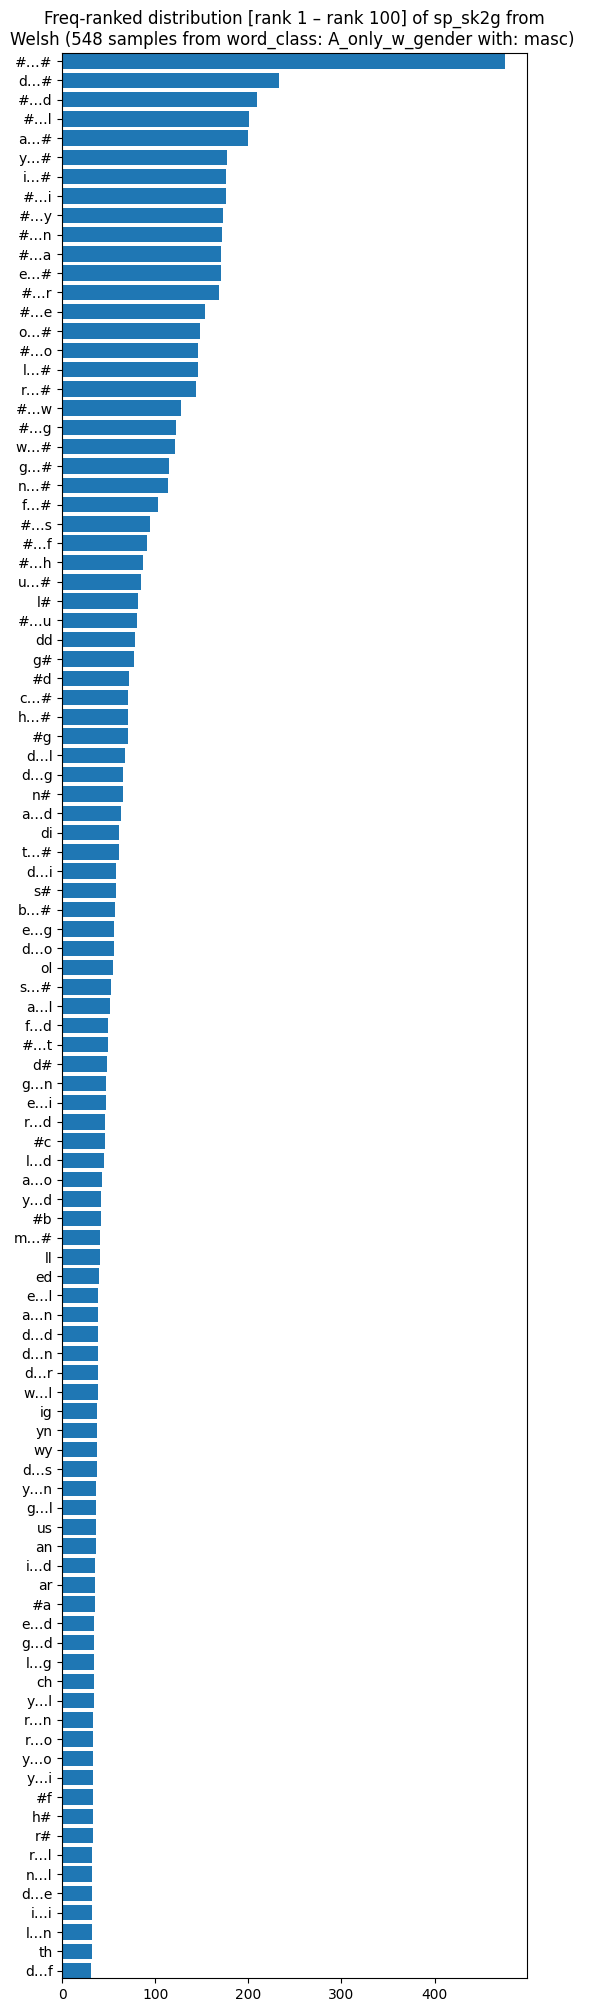

In [79]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 2
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [80]:
## spell skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk3gram
min_size: 1
supplement_var: sp_sk2gram
22      [#th, #t…e, #t…g, #t…#, #…he, #…h…g, #…h…#, #…...
725     [#dd, #d…w, #d…y, #d…s, #d…#, #…dw, #…d…y, #…d...
1014    [#as, #a…t, #a…u, #a…d, #a…#, #…st, #…s…u, #…s...
179     [#ty, #t…w, #t…y, #t…l, #t…l, #t…#, #…yw, #…y…...
389     [#mo, #m…e, #m…l, #m…#, #…oe, #…o…l, #…o…#, #…...
                              ...                        
1026    [#cl, #c…o, #c…f, #c…f, #c…#, #…lo, #…l…f, #…l...
724     [#dd, #d…i, #d…s, #d…t, #d…a, #d…w, #d…#, #…di...
615     [#ys, #y…g, #y…w, #y…n, #y…#, #…sg, #…s…w, #…s...
233     [#cy, #c…f, #c…i, #c…a, #c…w, #c…n, #c…#, #…yf...
374     [#ff, #f…o, #f…d, #f…u, #f…s, #f…#, #…fo, #…f…...
Name: sp_sk3gram, Length: 476, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25653/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


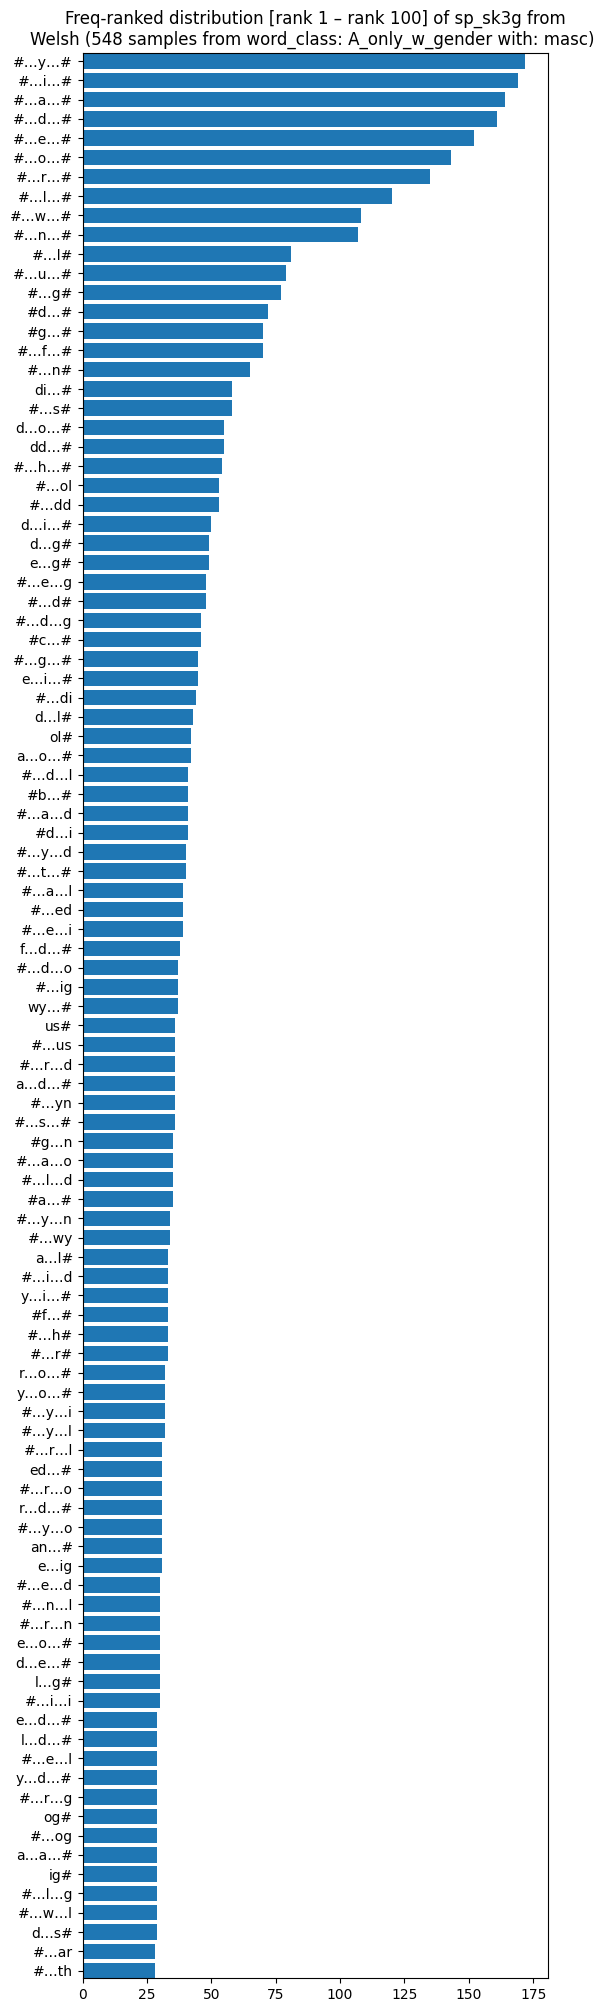

In [81]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 3
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [82]:
## spell skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk4gram
min_size: 1
supplement_var: sp_sk3gram
22      [#the, #th…g, #th…#, #t…eg, #t…e…#, #t…g#, #…h...
725     [#ddw, #dd…y, #dd…s, #dd…#, #d…wy, #d…w…s, #d…...
1014    [#ast, #as…u, #as…d, #as…#, #a…tu, #a…t…d, #a…...
179     [#tyw, #ty…y, #ty…l, #ty…l, #ty…#, #t…wy, #t…w...
389     [#moe, #mo…l, #mo…#, #m…el, #m…e…#, #m…l#, #…o...
                              ...                        
1026    [#clo, #cl…f, #cl…f, #cl…#, #c…of, #c…o…f, #c…...
724     [#ddi, #dd…s, #dd…t, #dd…a, #dd…w, #dd…#, #d…i...
615     [#ysg, #ys…w, #ys…n, #ys…#, #y…gw, #y…g…n, #y…...
233     [#cyf, #cy…i, #cy…a, #cy…w, #cy…n, #cy…#, #c…f...
374     [#ffo, #ff…d, #ff…u, #ff…s, #ff…#, #f…od, #f…o...
Name: sp_sk4gram, Length: 476, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25653/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


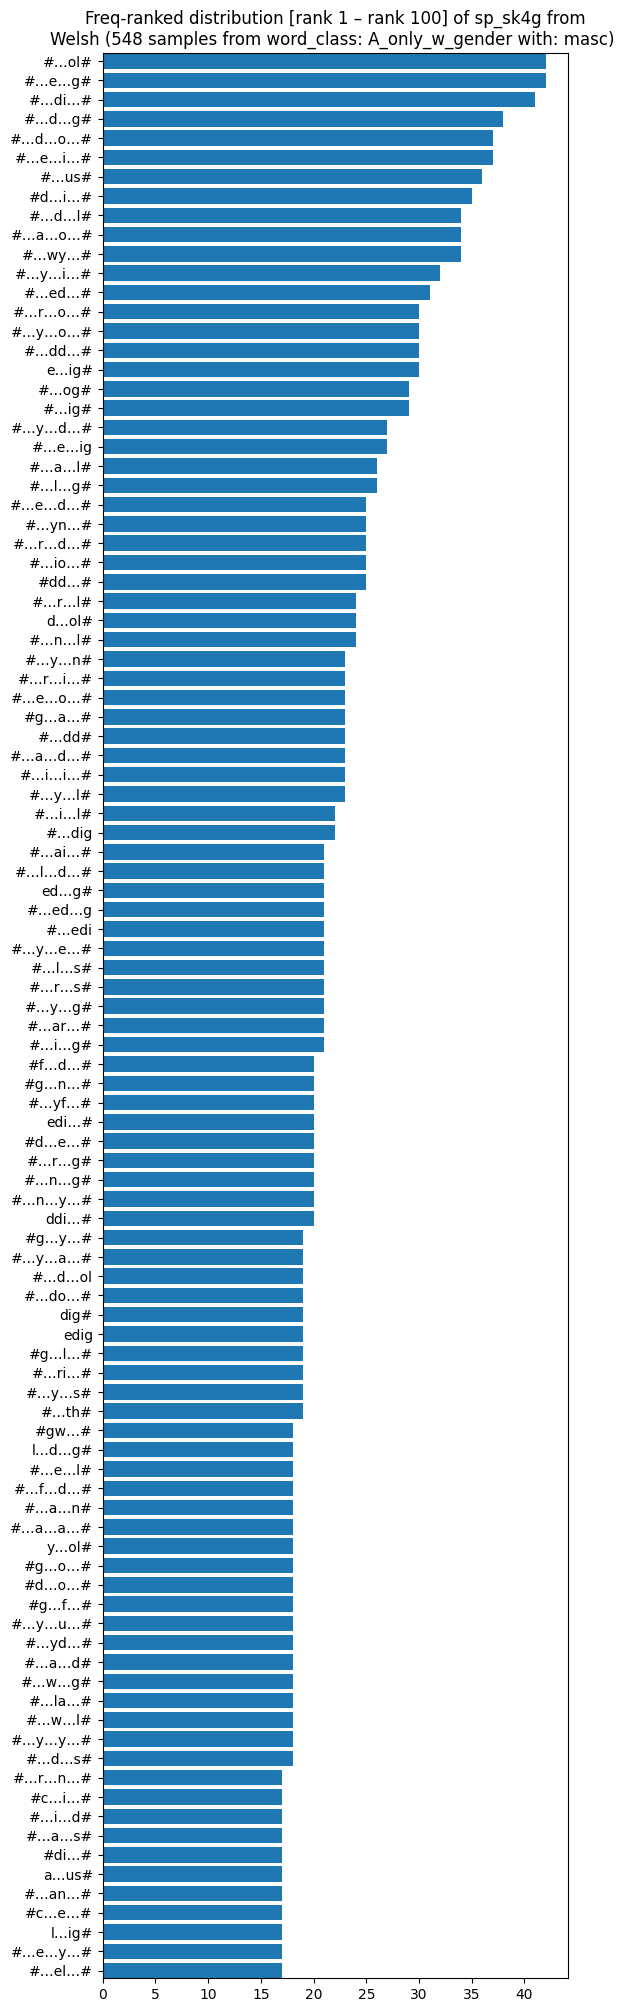

In [83]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 4
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [84]:
## spell skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, prefix = "sp_", skippy = True, inclusive = ngram_is_inclusive, inclusion_degree = inclusion_degree, check = False)

source_var: sp_1gram
target_var: sp_sk5gram
min_size: 1
supplement_var: sp_sk4gram
22      [#theg, #the…#, #th…g#, #t…eg#, #…heg#, theg#,...
725     [#ddwy, #ddw…s, #ddw…#, #dd…ys, #dd…y…#, #dd…s...
1014    [#astu, #ast…d, #ast…#, #as…ud, #as…u…#, #as…d...
179     [#tywy, #tyw…l, #tyw…l, #tyw…#, #ty…yl, #ty…y…...
389     [#moel, #moe…#, #mo…l#, #m…el#, #…oel#, moel#,...
                              ...                        
1026    [#clof, #clo…f, #clo…#, #cl…ff, #cl…f…#, #cl…f...
724     [#ddis, #ddi…t, #ddi…a, #ddi…w, #ddi…#, #dd…st...
615     [#ysgw, #ysg…n, #ysg…#, #ys…wn, #ys…w…#, #ys…n...
233     [#cyfi, #cyf…a, #cyf…w, #cyf…n, #cyf…#, #cy…ia...
374     [#ffod, #ffo…u, #ffo…s, #ffo…#, #ff…du, #ff…d…...
Name: sp_sk5gram, Length: 476, dtype: object


/var/folders/s2/lk8hdt6j10j0xyycw1lbjsm40000gn/T/ipykernel_25653/3820207768.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfx[target_var] = ngrams


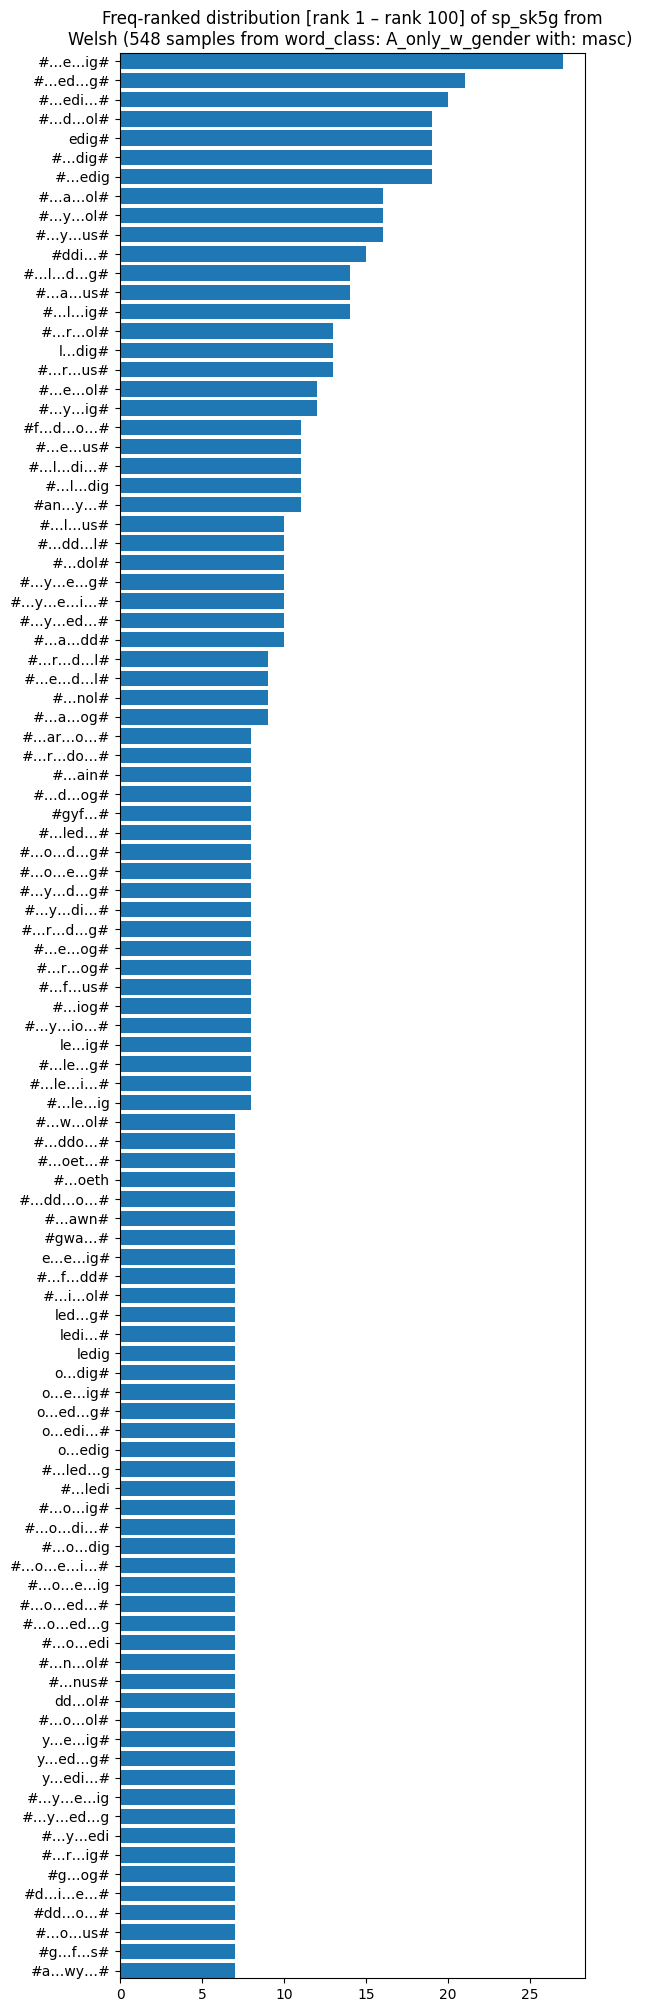

In [85]:
## frequency-ranked view
skippy = True
prefix = "sp_"
n_local = 5
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

## Sound

In [86]:
## stop for unimplemented language
if target_lang_name in [ 'Irish', 'Welsh' ]:
    import sys
    sys.exit()

SystemExit: 

/Volumes/K/opt/anaconda3/envs/py3.11/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3534: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Non-skippy sound

In [ ]:
## sound 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 2
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 3
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 4grams
add_ngram_to_df(df, n_for_ngram = 4, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 4
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = False, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = False
prefix = "sn_"
n_local = 5
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

### skippy sound

In [ ]:
## sound skippy 2grams
add_ngram_to_df(df, n_for_ngram = 2, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 2
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 3grams
add_ngram_to_df(df, n_for_ngram = 3, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 3
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 4grams
add_ngram_to_df(df, n_for_ngram = 4, prefix = "sn_", skippy = True, inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 4
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

In [ ]:
## sound skippy 5grams
add_ngram_to_df(df, n_for_ngram = 5, skippy = True, prefix = "sn_", inclusive = True, inclusion_degree = inclusion_degree, check = False)

In [ ]:
## frequency-ranked view
skippy = True
prefix = "sn_"
n_local = 5
#rank_range = (1,100)
#
R = get_terms_by_freq_rank(df, rank_range, prefix = prefix, n_for_ngram = n_local, skippy = skippy, check = False)
#
show_terms_with_ranking(R, rank_range, prefix = prefix, skippy = skippy, n_for_ngram = n_local, check = False)

# End